In [2]:
import os
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from abc import ABC, abstractmethod
from transformers import ViTForImageClassification, ViTImageProcessor
import torch
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

# 1) Load .env
load_dotenv()

class PipelineStep(ABC):
    """Abstract base class for pipeline steps."""
    
    @abstractmethod
    def process(self, data):
        """Process the input data and return the transformed output."""
        pass

class AllenAPI:
    """Singleton class for accessing Allen Brain Observatory API"""
    
    _instance = None
    _boc = None  # Lazy-loaded BrainObservatoryCache instance

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    @property
    def boc(self):
        """Lazy-load BrainObservatoryCache only when accessed."""
        if self._boc is None:
            allen_cache_path = os.environ.get('CAIM_ALLEN_CACHE_PATH')
            if not allen_cache_path:
                raise ValueError("AllenAPI requires a valid cache path. Set `CAIM_ALLEN_CACHE_PATH` in .env.")

            manifest_path = Path(allen_cache_path) / 'brain_observatory_manifest.json'
            self._boc = BrainObservatoryCache(manifest_file=str(manifest_path))

        return self._boc

    def get_boc(self):
        """Retrieve the BrainObservatoryCache object, ensuring it is initialized."""
        return self.boc
import os
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

class AllenAPI:
    """Singleton class for accessing Allen Brain Observatory API"""
    
    _instance = None
    _boc = None  # Lazy-loaded BrainObservatoryCache instance

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    @property
    def boc(self):
        """Lazy-load BrainObservatoryCache only when accessed."""
        if self._boc is None:
            allen_cache_path = os.environ.get('CAIM_ALLEN_CACHE_PATH')
            if not allen_cache_path:
                raise ValueError("AllenAPI requires a valid cache path. Set `CAIM_ALLEN_CACHE_PATH` in .env.")

            manifest_path = Path(allen_cache_path) / 'brain_observatory_manifest.json'
            self._boc = BrainObservatoryCache(manifest_file=str(manifest_path))

        return self._boc

    def get_boc(self):
        """Retrieve the BrainObservatoryCache object, ensuring it is initialized."""
        return self.boc

# Create a global instance so that all files can use it
allen_api = AllenAPI()

class AllenStimuliFetchStep(PipelineStep):
    """
    Fetches data from the Allen Brain Observatory.
    The session IDs are hard-coded since the stimuli are always the same.
    """
    # Hard-coded sessions
    SESSION_A = 501704220
    SESSION_B = 501559087
    SESSION_C = 501474098

    def __init__(self, boc):
        """
        :param boc: BrainObservatoryCache instance (via the AllenAPI singleton).
        """
        self.boc = boc

    def process(self, data):
        """
        Expects data to be either None or have (container_id, session, stimulus).
        We fetch a dictionary of raw stimuli arrays, store them in data['raw_data_dct'].
        """
        if isinstance(data, tuple):
            container_id, session, stimulus = data
            data = {'container_id': container_id, 'session': session, 'stimulus': stimulus}
        elif data is None:
            data = {}

        raw_data_dct = {}

        movie_one_dataset = self.boc.get_ophys_experiment_data(self.SESSION_A)
        raw_data_dct['natural_movie_one'] = movie_one_dataset.get_stimulus_template('natural_movie_one')

        movie_two_dataset = self.boc.get_ophys_experiment_data(self.SESSION_C)
        raw_data_dct['natural_movie_two'] = movie_two_dataset.get_stimulus_template('natural_movie_two')

        movie_three_dataset = self.boc.get_ophys_experiment_data(self.SESSION_A)
        raw_data_dct['natural_movie_three'] = movie_three_dataset.get_stimulus_template('natural_movie_three')

        natural_images_dataset = self.boc.get_ophys_experiment_data(self.SESSION_B)
        raw_data_dct['natural_scenes'] = natural_images_dataset.get_stimulus_template('natural_scenes')

        data['raw_data_dct'] = raw_data_dct
        return data

class AnalysisPipeline:
    """Executes a series of PipelineStep objects in order."""
    
    def __init__(self, steps):
        self.steps = steps
    
    def run(self, data):
        for step in self.steps:
            data = step.process(data)
        return data

# Create a global instance so that all files can use it
allen_api = AllenAPI()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

    # F) Build pipeline with all steps
boc = allen_api.get_boc()
pipeline = AnalysisPipeline([
        AllenStimuliFetchStep(boc)])

raw_data_dct=pipeline.run(None)
'''
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])'''

/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


'\ninputs = processor(images=image, return_tensors="pt")\noutputs = model(**inputs)\nlogits = outputs.logits\n# model predicts one of the 1000 ImageNet classes\npredicted_class_idx = logits.argmax(-1).item()\nprint("Predicted class:", model.config.id2label[predicted_class_idx])'

In [3]:
images=raw_data_dct['raw_data_dct']['natural_scenes']

print(images.shape)

(118, 918, 1174)


In [35]:
import pickle

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl"

try:
    with open(path, "rb") as f:
        embeddings = pickle.load(f)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {path}")
except EOFError:
    print("Error: File might be corrupted or incomplete.")
except pickle.UnpicklingError:
    print("Error: Issue with unpickling the file. Try a different encoding.")
except Exception as e:
    print(f"Unexpected error: {e}")

File loaded successfully!


In [5]:
print(images)

[[[165. 165. 165. ...  69.  54.  54.]
  [165. 165. 165. ...  69.  54.  54.]
  [165. 165. 165. ...  69.  54.  54.]
  ...
  [144. 144. 144. ... 161. 197. 197.]
  [131. 131. 131. ... 231. 244. 244.]
  [131. 131. 131. ... 231. 244. 244.]]

 [[ 77.  77.  77. ...  79.  95.  95.]
  [ 77.  77.  77. ...  79.  95.  95.]
  [ 77.  77.  77. ...  79.  95.  95.]
  ...
  [ 63.  63.  63. ...  86.  87.  87.]
  [ 70.  70.  70. ...  47.  51.  51.]
  [ 70.  70.  70. ...  47.  51.  51.]]

 [[193. 193. 193. ... 178. 186. 186.]
  [193. 193. 193. ... 178. 186. 186.]
  [193. 193. 193. ... 178. 186. 186.]
  ...
  [176. 176. 176. ... 218. 215. 215.]
  [173. 173. 173. ... 211. 211. 211.]
  [173. 173. 173. ... 211. 211. 211.]]

 ...

 [[ 64.  64.  64. ...  33.  33.  34.]
  [ 64.  64.  64. ...  33.  33.  34.]
  [ 61.  61.  61. ...  35.  35.  33.]
  ...
  [128. 128. 129. ...  85.  85.  82.]
  [128. 128. 129. ...  85.  85.  82.]
  [123. 123. 129. ...  84.  84.  84.]]

 [[ 21.  21.  29. ... 107. 107. 112.]
  [ 21.  21.

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def classify_image(image):
    # Convert NumPy image to PIL format
    image_pil = Image.fromarray((image).astype(np.uint8))  # Ensure proper format

    # Convert to PyTorch tensor and process
    inputs = processor(images=image_pil, return_tensors="pt")
    
    # Ensure model is on the same device as inputs
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    
    return model.config.id2label[predicted_class_idx]

# Convert grayscale to RGB
images_rgb = np.repeat(images[:, :, :, np.newaxis], 3, axis=-1)  # Shape: (118, 918, 1174, 3)

# Loop over images, classify, and display one at a time
labels = []
for i in range(118):
    image = images_rgb[i]
    
    label = classify_image(image)
    print(label)
    labels.append(label)
    #plt.imshow(image / 255)  # Ensure correct range for display
    #plt.axis("off")
    #plt.show()


brown bear, bruin, Ursus arctos
brown bear, bruin, Ursus arctos
brown bear, bruin, Ursus arctos
mud turtle
albatross, mollymawk
lion, king of beasts, Panthera leo
lion, king of beasts, Panthera leo
lion, king of beasts, Panthera leo
tusker
tusker
zebra
tiger, Panthera tigris
tiger, Panthera tigris
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
coyote, prairie wolf, brush wolf, Canis latrans
cheetah, chetah, Acinonyx jubatus
leopard, Panthera pardus
leopard, Panthera pardus
bald eagle, American eagle, Haliaeetus leucocephalus
kite
canoe
pelican
leopard, Panthera pardus
baboon
hummingbird
otter
whiptail, whiptail lizard
zebra
quail
red wolf, maned wolf, Canis rufus, Canis niger
worm fence, snake fence, snake-rail fence, Virginia fence
megalith, megalithic structure
gazelle
Siberian husky
tusker
kite
ram, tup
valley, vale
hay
Egyptian cat
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
l

In [18]:
from collections import Counter
counts=Counter(labels)
print(counts)
label_counts = sorted(Counter(labels), key=lambda x: x[1], reverse=False)
print(label_counts)
len(label_counts)

Counter({'park bench': 10, 'daisy': 4, 'brown bear, bruin, Ursus arctos': 3, 'albatross, mollymawk': 3, 'lion, king of beasts, Panthera leo': 3, 'tusker': 3, 'leopard, Panthera pardus': 3, 'kite': 3, 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle': 3, 'picket fence, paling': 3, 'zebra': 2, 'tiger, Panthera tigris': 2, 'whiptail, whiptail lizard': 2, 'red wolf, maned wolf, Canis rufus, Canis niger': 2, 'gazelle': 2, 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus': 2, 'great grey owl, great gray owl, Strix nebulosa': 2, 'lakeside, lakeshore': 2, 'vase': 2, 'pole': 2, 'bannister, banister, balustrade, balusters, handrail': 2, 'chainlink fence': 2, 'rubber eraser, rubber, pencil eraser': 2, 'mud turtle': 1, 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor': 1, 'coyote, prairie wolf, brush wolf, Canis latrans': 1, 'cheetah, chetah, Acinonyx jubatus': 1, 'bald eagle, American eagle, Haliaeetus leucocephalus': 1, 'canoe': 1, 'pelican':

77

In [14]:
for label, count in label_counts.items():
    print(f"{label}: {count}")

AttributeError: 'list' object has no attribute 'items'

In [31]:
labels

['brown bear, bruin, Ursus arctos',
 'brown bear, bruin, Ursus arctos',
 'brown bear, bruin, Ursus arctos',
 'mud turtle',
 'albatross, mollymawk',
 'lion, king of beasts, Panthera leo',
 'lion, king of beasts, Panthera leo',
 'lion, king of beasts, Panthera leo',
 'tusker',
 'tusker',
 'zebra',
 'tiger, Panthera tigris',
 'tiger, Panthera tigris',
 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 'coyote, prairie wolf, brush wolf, Canis latrans',
 'cheetah, chetah, Acinonyx jubatus',
 'leopard, Panthera pardus',
 'leopard, Panthera pardus',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'kite',
 'canoe',
 'pelican',
 'leopard, Panthera pardus',
 'baboon',
 'hummingbird',
 'otter',
 'whiptail, whiptail lizard',
 'zebra',
 'quail',
 'red wolf, maned wolf, Canis rufus, Canis niger',
 'worm fence, snake fence, snake-rail fence, Virginia fence',
 'megalith, megalithic structure',
 'gazelle',
 'Siberian husky',
 'tusker',
 'kite',
 'ram, tup',
 'valley

In [36]:
embeddings=embeddings['natural_scenes']

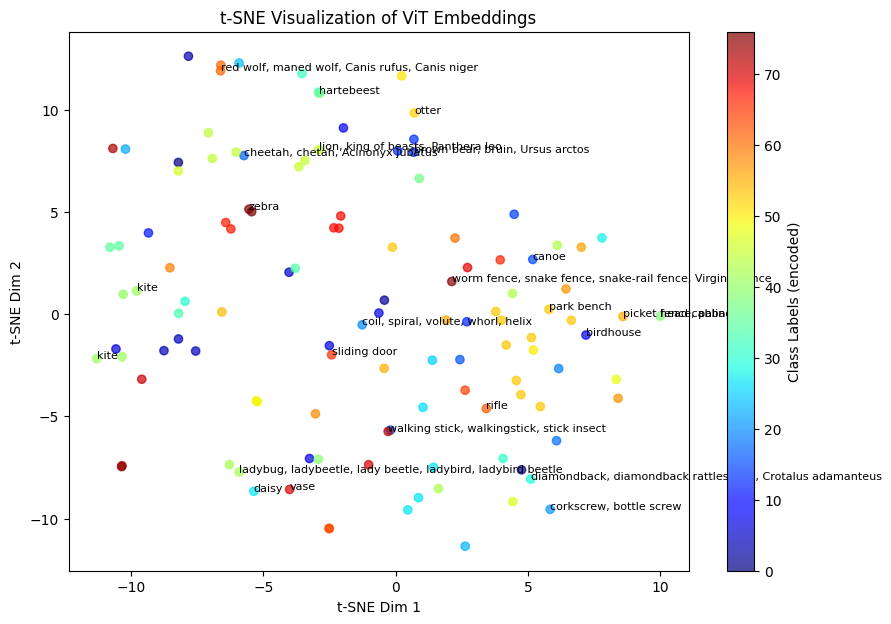

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Example: `embeddings` is (N, embedding_dim), `labels` is a list of class names
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)  # Convert to numbers

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], c=numeric_labels, cmap='jet', alpha=0.7
)
plt.colorbar(label="Class Labels (encoded)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Visualization of ViT Embeddings")

# Optional: Annotate some points with their class names
for i in range(0, len(labels), len(labels) // 20):  # Sample annotations to avoid clutter
    plt.annotate(labels[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.show()


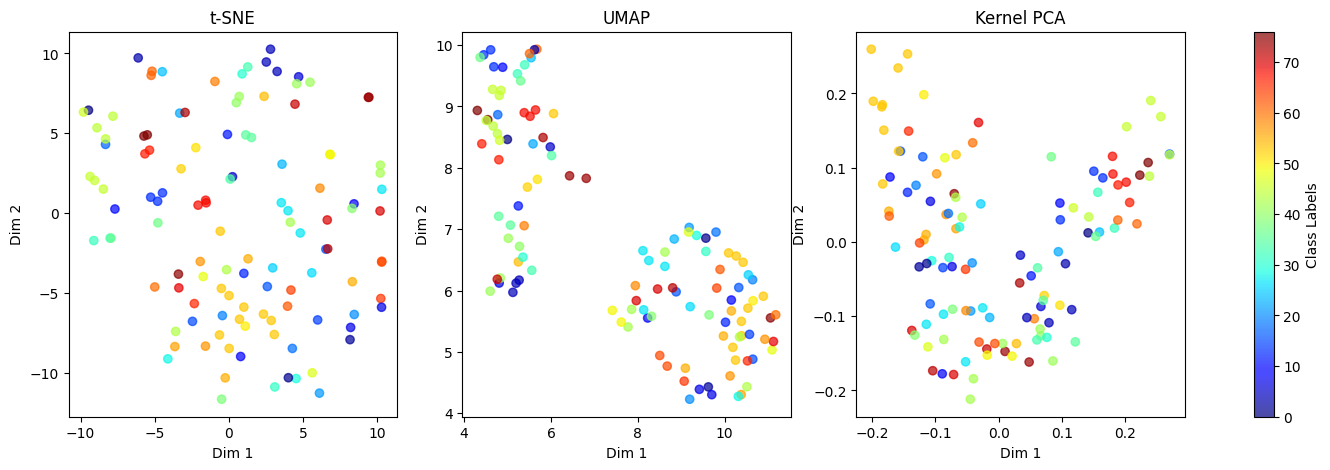

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import umap

for ax, (reducer, title) in zip(
    axes, 
    [(TSNE(n_components=2), "t-SNE"), (umap.UMAP(n_components=2), "UMAP"), (KernelPCA(n_components=2, kernel='rbf'), "Kernel PCA")]
):
    embeddings_2d = reducer.fit_transform(embeddings)
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=numeric_labels, cmap="jet", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

fig.colorbar(scatter, ax=axes, orientation="vertical", label="Class Labels")
plt.show()

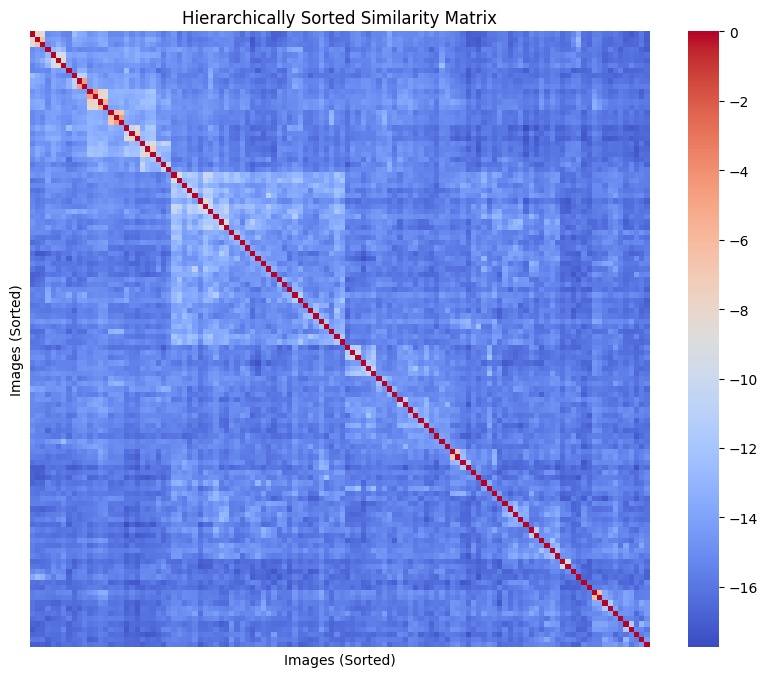

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute Dot Product Similarity (N x N matrix)
dot_similarity = embeddings @ embeddings.T  # Dot product similarity

# Compute Euclidean Distance Matrix (N x N)
euclidean_distance = squareform(pdist(embeddings, metric="euclidean"))

# Choose which one to use (dot product or euclidean)
similarity_matrix = -euclidean_distance  # Negative because clustering assumes similarity
#similarity_matrix=dot_similarity

# Perform hierarchical clustering to reorder
linkage_matrix = linkage(similarity_matrix, method="ward")
dendro = dendrogram(linkage_matrix, no_plot=True)
reordered_idx = dendro["leaves"]

# Reorder the similarity matrix
sorted_similarity = similarity_matrix[np.ix_(reordered_idx, reordered_idx)]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarity, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Hierarchically Sorted Similarity Matrix")
plt.xlabel("Images (Sorted)")
plt.ylabel("Images (Sorted)")
plt.show()


/tmp/ipykernel_3131360/1254656639.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(euclidean_distance, method="ward")


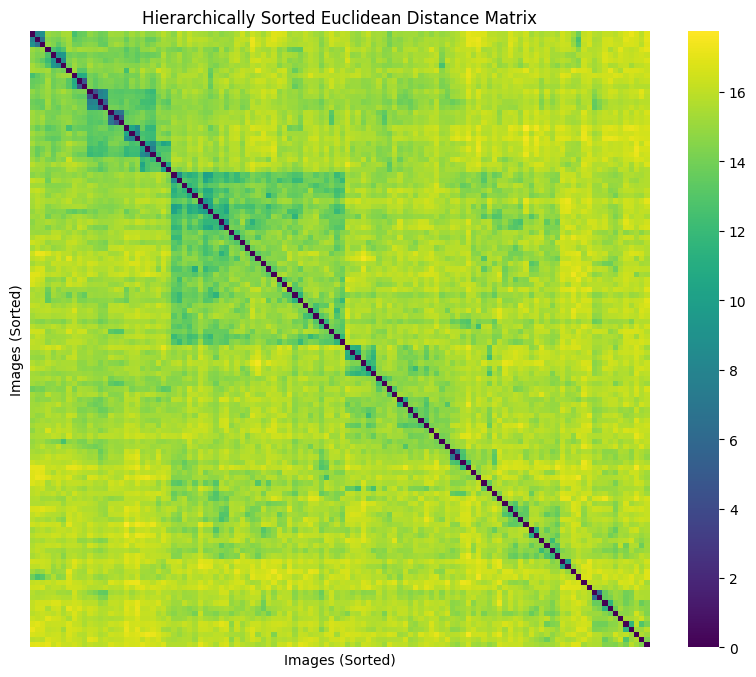

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute Euclidean Distance Matrix (N x N)
euclidean_distance = squareform(pdist(embeddings, metric="euclidean"))

# Perform hierarchical clustering to reorder images based on similarity
linkage_matrix = linkage(euclidean_distance, method="ward")
dendro = dendrogram(linkage_matrix, no_plot=True)
reordered_idx = dendro["leaves"]

# Reorder the Euclidean distance matrix based on clustering
sorted_distance = euclidean_distance[np.ix_(reordered_idx, reordered_idx)]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_distance, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Hierarchically Sorted Euclidean Distance Matrix")
plt.xlabel("Images (Sorted)")
plt.ylabel("Images (Sorted)")
plt.show()


/tmp/ipykernel_3131360/1300008975.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(euclidean_distance, method="ward")


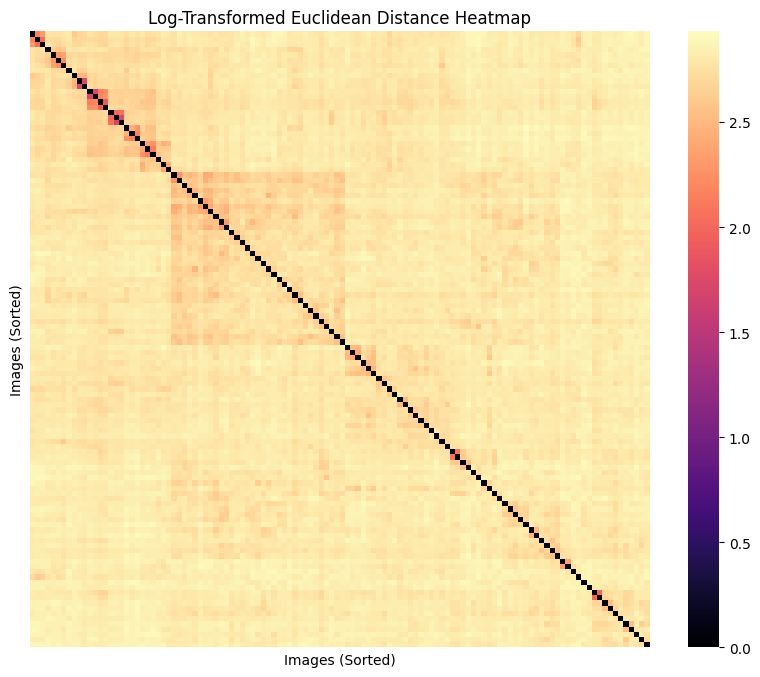

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute Euclidean Distance Matrix (N x N)
euclidean_distance = squareform(pdist(embeddings, metric="euclidean"))

# Apply log transformation to enhance differences
log_distance = np.log1p(euclidean_distance)  # log(1 + d) prevents log(0) issues

# Hierarchical clustering for sorting
linkage_matrix = linkage(euclidean_distance, method="ward")
dendro = dendrogram(linkage_matrix, no_plot=True)
reordered_idx = dendro["leaves"]

# Reorder matrix for better visualization
sorted_distance = log_distance[np.ix_(reordered_idx, reordered_idx)]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_distance, cmap="magma", xticklabels=False, yticklabels=False)
plt.title("Log-Transformed Euclidean Distance Heatmap")
plt.xlabel("Images (Sorted)")
plt.ylabel("Images (Sorted)")
plt.show()


(array([3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 6.000e+00, 1.200e+01, 1.400e+01, 2.800e+01, 3.400e+01,
        7.000e+01, 1.090e+02, 1.760e+02, 2.650e+02, 5.640e+02, 1.016e+03,
        1.475e+03, 1.561e+03, 1.043e+03, 4.020e+02, 9.200e+01, 5.000e+00]),
 array([ 4.5892436 ,  5.02783095,  5.46641831,  5.90500567,  6.34359303,
         6.78218039,  7.22076775,  7.6593551 ,  8.09794246,  8.53652982,
         8.97511718,  9.41370454,  9.85229189, 10.29087925, 10.72946661,
        11.16805397, 11.60664133, 12.04522868, 12.48381604, 12.9224034 ,
        13.36099076, 13.79957812, 14.23816547, 14.67675283, 15.11534019,
        15.55392755, 15.99251491, 16.43110226, 16.86968962, 17.30827698,
        17.74686434]),
 <BarContainer object of 30 artists>)

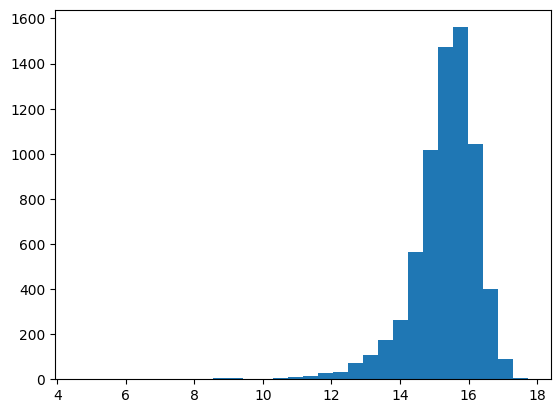

In [58]:
plt.hist(pdist(embeddings, metric="euclidean"), bins=30)

In [50]:
embeddings.shape

(118, 768)

/tmp/ipykernel_3131360/1403036781.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_pca = linkage(euclidean_distance_pca, method="ward")


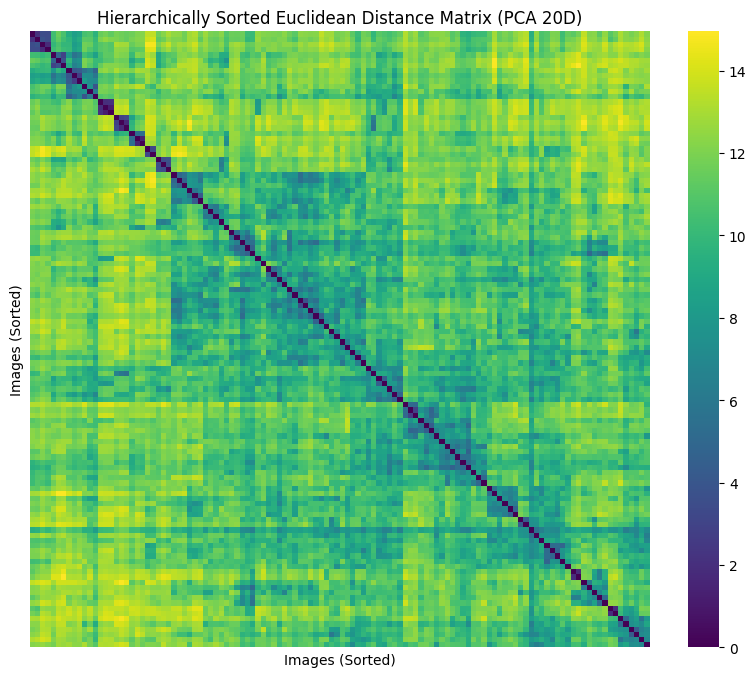

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA

# Assuming `embeddings` is your high-dimensional ViT embedding matrix (N x D)
# Replace with actual embeddings variable if needed

# Perform PCA to reduce embeddings to 20 dimensions
pca = PCA(n_components=20)
embeddings_pca = pca.fit_transform(embeddings)  # Shape: (N, 20)

# Compute Euclidean Distance Matrix on PCA-reduced embeddings
euclidean_distance_pca = squareform(pdist(embeddings_pca, metric="euclidean"))

# Perform hierarchical clustering for sorting
linkage_matrix_pca = linkage(euclidean_distance_pca, method="ward")
dendro_pca = dendrogram(linkage_matrix_pca, no_plot=True)
reordered_idx_pca = dendro_pca["leaves"]

# Reorder the PCA-based distance matrix
sorted_distance_pca = euclidean_distance_pca[np.ix_(reordered_idx_pca, reordered_idx_pca)]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_distance_pca, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Hierarchically Sorted Euclidean Distance Matrix (PCA 20D)")
plt.xlabel("Images (Sorted)")
plt.ylabel("Images (Sorted)")
plt.show()


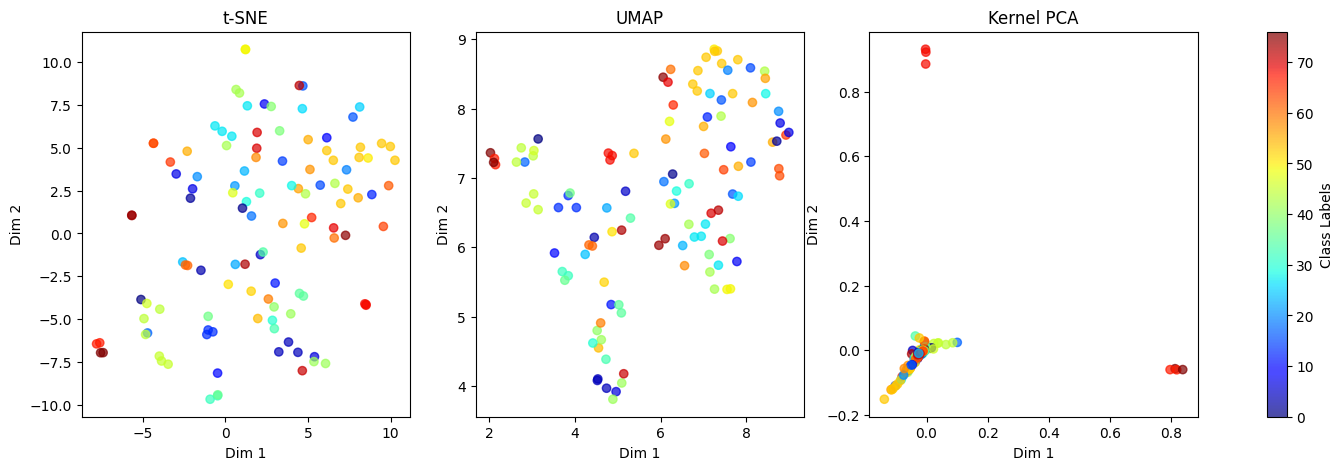

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import umap

for ax, (reducer, title) in zip(
    axes, 
    [(TSNE(n_components=2), "t-SNE"), (umap.UMAP(n_components=2), "UMAP"), (KernelPCA(n_components=2, kernel='rbf'), "Kernel PCA")]
):
    embeddings_2d = reducer.fit_transform(embeddings_pca)
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=numeric_labels, cmap="jet", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

fig.colorbar(scatter, ax=axes, orientation="vertical", label="Class Labels")
plt.show()

/tmp/ipykernel_3131360/919439778.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap = mcolors.ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors[:num_classes])


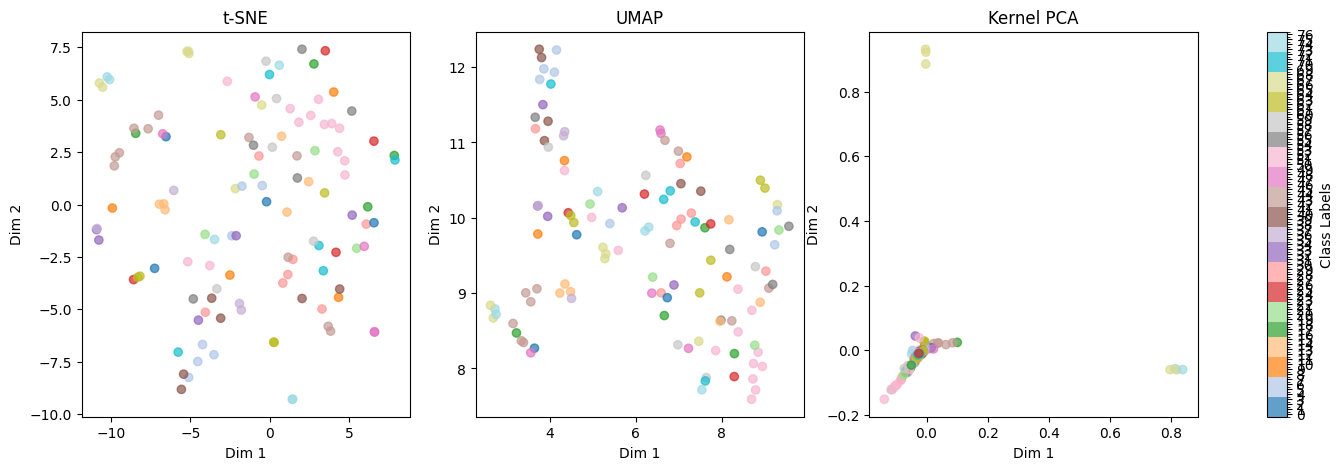

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import umap
import matplotlib.colors as mcolors

# Ensure labels are discrete integers from 0 to 76
unique_labels = np.unique(numeric_labels)
num_classes = len(unique_labels)  # Should be 77

# Define a discrete colormap with 77 distinct colors
discrete_cmap = mcolors.ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors[:num_classes])

# Create a normalization function to map labels to colormap bins
norm = mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (reducer, title) in zip(
    axes, 
    [(TSNE(n_components=2), "t-SNE"), (umap.UMAP(n_components=2), "UMAP"), (KernelPCA(n_components=2, kernel='rbf'), "Kernel PCA")]
):
    embeddings_2d = reducer.fit_transform(embeddings_pca)
    scatter = ax.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1], 
        c=numeric_labels, cmap=discrete_cmap, norm=norm, alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

# Add a discrete colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation="vertical", ticks=np.arange(num_classes))
cbar.set_label("Class Labels")
cbar.set_ticklabels(unique_labels)  # Set tick labels to actual label numbers

plt.show()


In [64]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

# Compute the full pairwise Euclidean distance matrix
distance_matrix = squareform(pdist(embeddings_pca, metric="euclidean"))

# Get unique labels and their indices
unique_labels = np.unique(numeric_labels)
intra_distances = []
inter_distances = []

# Compute intra-class and inter-class distances
for label in unique_labels:
    indices = np.where(numeric_labels == label)[0]  # Indices of this class
    
    if len(indices) > 1:  # Intra-class distances only exist if multiple samples per class
        intra_class_dists = pdist(embeddings_pca[indices], metric="euclidean")
        intra_distances.extend(intra_class_dists)

    # Compute inter-class distances (distances to all points in other classes)
    other_indices = np.where(numeric_labels != label)[0]
    inter_class_dists = distance_matrix[np.ix_(indices, other_indices)].flatten()
    inter_distances.extend(inter_class_dists)

# Convert lists to numpy arrays
intra_distances = np.array(intra_distances)
inter_distances = np.array(inter_distances)

# Compute statistics
mean_intra = np.mean(intra_distances) if len(intra_distances) > 0 else np.nan
mean_inter = np.mean(inter_distances)
ratio = mean_intra / mean_inter if mean_inter > 0 else np.nan

print(f"Mean Intra-Class Distance: {mean_intra:.4f}")
print(f"Mean Inter-Class Distance: {mean_inter:.4f}")
print(f"Intra/Inter Distance Ratio: {ratio:.4f}")


Mean Intra-Class Distance: 6.5077
Mean Inter-Class Distance: 10.8964
Intra/Inter Distance Ratio: 0.5972
